In [1]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, \
                            pairwise_distances, \
                            mean_squared_error
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

np.random.seed(129)

# FashionMNIST

In [2]:
training_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


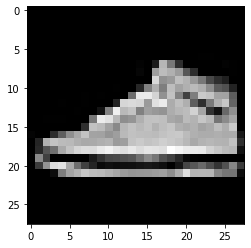

Label: 7


In [4]:
# Display image and label.
batch_x, batch_y = next(iter(train_dataloader))
print(f"Feature batch shape: {batch_x.size()}")
print(f"Labels batch shape: {batch_y.size()}")
img = batch_x[0].squeeze()
label = batch_y[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [5]:
dim_num = training_data[0][0].size()[1] *  training_data[0][0].size()[2]
dim_num

784

# Define Network(s)

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

class NeuralNetwork(nn.Module):
    def __init__(self, n_hidden=256):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim_num, n_hidden),
            nn.ReLU(),
            #nn.Dropout(.1),
            #nn.Linear(n_hidden, n_hidden),
            #nn.ReLU(),
            #nn.Dropout(.1),
            nn.Linear(n_hidden, 10),
            #nn.Softmax(-1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def getNeuralNet(dim_num=784, n_hidden=256, n_classes=10):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(dim_num, n_hidden),
        nn.ReLU(),
        #nn.Dropout(.1),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        #nn.Dropout(.1),
        nn.Linear(n_hidden, n_classes)
    )

Using cpu device


In [58]:
# two networks of different sizes to be trained
net1 = getNeuralNet(dim_num, 32, 10)
net2 = getNeuralNet(dim_num,  8, 10)
# another network to stay randomly initialized
net3 = getNeuralNet(dim_num,  8, 10) 

In [59]:
#for name, param in model.named_parameters():
#    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [60]:
learning_rate = 1e-3
#batch_size = 64
epochs = 4
loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(net1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=learning_rate)

# Training

In [61]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    train_losses = []
    for step, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
    return np.mean(train_losses)


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    predictions = []
    
    with torch.no_grad():
        for X,y in dataloader:
            # Compute prediction and loss
            pred = model(X)
            predictions.append(pred)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return predictions

In [62]:
losses1, losses2 = [], []
from rich.progress import track
for t in range(epochs):
    print("Epoch {}/{}".format(t+1,epochs))
    losses1.append(train_loop(train_dataloader, net1, loss_fn, optimizer1))
    losses2.append(train_loop(train_dataloader, net2, loss_fn, optimizer2))
    #test_loop(test, test_labels, model, loss_fn)
print("Done!")

Epoch 1/4
Epoch 2/4
Epoch 3/4
Epoch 4/4
Done!


In [63]:
predictions1 = test_loop(test_dataloader, net1, loss_fn)
predictions2 = test_loop(test_dataloader, net2, loss_fn)
predictions3 = test_loop(test_dataloader, net3, loss_fn)

Test Error: 
 Accuracy: 85.3%, Avg loss: 0.006446 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.008034 

Test Error: 
 Accuracy: 7.9%, Avg loss: 0.036435 



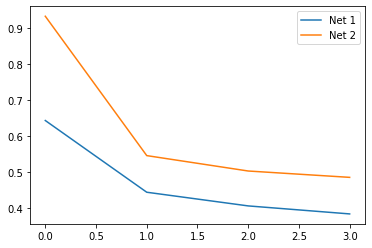

In [64]:
import matplotlib.pyplot as plt
plt.plot(losses1, label='Net 1')
plt.plot(losses2, label='Net 2')
plt.legend()
plt.show()

# Embeddings

In [65]:
# Define function to get subnet from given network at index
def get_subnet(parent_net, break_layer_idx = '1'):
    children_list = []
    for n,c in parent_net.named_children():
        children_list.append(c)
        if n == break_layer_idx:
            break
    sub_net = nn.Sequential(*children_list)
    return sub_net

In [66]:
# Print one of the original networks as reference
#net1

In [67]:
# Get the subnetworks
sub_net1 = get_subnet(net1)
sub_net2 = get_subnet(net2)
sub_net3 = get_subnet(net3)

In [68]:
#sub_net1

In [69]:
# Get DataLoader with larger batch_size
dl = DataLoader(training_data, batch_size=400, shuffle=False)
batch_x, batch_y = next(iter(dl))

In [70]:
# Get embeddings for batch
emb1 = sub_net1(batch_x).detach().numpy()
emb2 = sub_net2(batch_x).detach().numpy()
emb3 = sub_net3(batch_x).detach().numpy()

In [71]:
emb1.shape,emb2.shape,emb3.shape

((400, 32), (400, 8), (400, 8))

In [72]:
# Get t-SNE embeddings for the outputs
from sklearn.manifold import TSNE
tsne1 = TSNE(n_components=2).fit_transform(emb1)
tsne2 = TSNE(n_components=2).fit_transform(emb2)
tsne3 = TSNE(n_components=2).fit_transform(emb3)

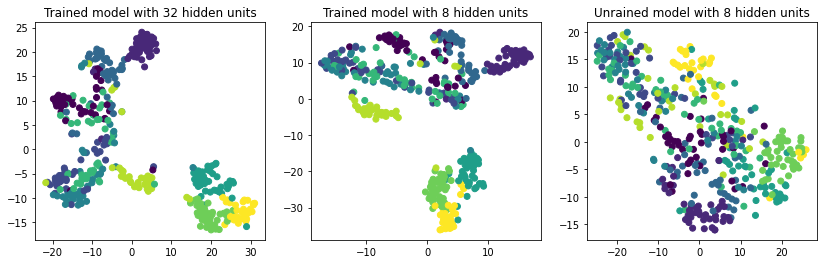

In [73]:
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.title('Trained model with 32 hidden units')
plt.scatter(tsne1[:,0], tsne1[:,1], c=batch_y)
plt.subplot(132)
plt.title('Trained model with 8 hidden units')
plt.scatter(tsne2[:,0], tsne2[:,1], c=batch_y)
plt.subplot(133)
plt.title('Unrained model with 8 hidden units')
plt.scatter(tsne3[:,0], tsne3[:,1], c=batch_y)
plt.show()

# Embedding Fitness

In [114]:
from sklearn.manifold._t_sne import _joint_probabilities, pairwise_distances
from scipy.spatial.distance import pdist

class TSNELoss():
    
    def __init__(self, parent_embeds, use_gaussians=True):
        
        # Cutoff to protect from division by zero errors
        self.MACHINE_EPSILON = np.finfo(np.double).eps
        
        # Hard code the perplexity param from TSNE
        self.perplexity = 30.0
        
        # Whether to use Gaussian PDFs for children
        self.use_gaussians = use_gaussians
        
        # Initialize loss funciton with parent embeddings
        self._load_joint_probs(parent_embeds)
    
    def _load_joint_probs(self, parent_embeds):
        """
        Load the loss function with the parent's joint probability 
        distribution over the pairwise distances.
        
        Parameters
        ----------
        parent_embeds : array-like of shape (n_samples, n_parent_neurons)
            Embeddings of the parent/base network
        """
        
        # Compute pairwise distance matrix
        distances = pairwise_distances(
            parent_embeds, 
            metric='euclidean', 
            squared=True
        )

        if np.any(distances < 0):
            raise ValueError("All distances should be positive, the "
                             "metric given is not correct")

        # Compute the joint probability distribution for the input space
        P = _joint_probabilities(distances, self.perplexity, verbose=0)
        
        assert np.all(np.isfinite(P)), "All probabilities should be finite"
        assert np.all(P >= 0), "All probabilities should be non-negative"
        assert np.all(P <= 1), ("All probabilities should be less "
                                "or then equal to one")
        
        self.P = P

    def _child_dist(self, X_embedded, degrees_of_freedom, use_gaussians):
        """
        Get distribution over child layers' embeddings.

        Parameters
        ----------
        X_embedded : array-like of shape (n_samples, n_neurons)
            Embeddings of the child network's layer.
        degrees_of_freedom : int or float
            Degrees of freedom of the Student's t-distribution.
        use_gaussians : bool
            Compute distribution in child embeddings space using Gaussians.
            Else use Student's t-Distribution.
            
        Returns
        -------
        Q : array-like
            Distribution of child embeddings
        """
        
        if use_gaussians:
            dist = pairwise_distances(
                X_embedded, 
                metric='euclidean', 
                squared=True
            )
            Q = _joint_probabilities(dist, self.perplexity, 0)
        else:
            # Q is a heavy-tailed distribution: Student's t-distribution
            dist = pdist(X_embedded, "sqeuclidean")
            #return dist
            dist /= degrees_of_freedom
            dist += 1.
            dist **= (degrees_of_freedom + 1.0) / -2.0
            Q = np.maximum(dist / (2.0 * np.sum(dist)), self.MACHINE_EPSILON)
        
        return Q
        
    def _kl_div(self, Q):
        """
        Compute the KL divergence between distributions over the
        parent and child layers' embeddings.        
        
        Parameters
        ----------
        Q : array-like
            Distribution of child embeddings
        
        Returns
        -------
        kl_divergence : float
            Kullback-Leibler divergence of p_ij and q_ij.
        """

        # Optimization trick below: np.dot(x, y) is faster than
        # np.sum(x * y) because it calls BLAS

        # Objective: C (Kullback-Leibler divergence of P and Q)
        kl_divergence = 2.0 * np.dot(
            self.P, np.log(np.maximum(self.P, self.MACHINE_EPSILON) / Q))
            
        return kl_divergence

    def __call__(self, compressed_embeds):
        
        # Set the degrees of freedom for the Q distribution as
        # the number of neurons in the child's layer
        degrees_of_freedom = compressed_embeds.shape[1]
        
        Q = self._child_dist(
            compressed_embeds, 
            degrees_of_freedom, 
            self.use_gaussians
        )
        
        loss = self._kl_div(Q)
        
        return loss

In [121]:
from utils import measure_exec_time

In [122]:
tsne_loss = TSNELoss(emb1, use_gaussians=False)

In [123]:
loss_val = tsne_loss(emb2)
print(loss_val)

0.6671456683896446


In [124]:
loss_val = tsne_loss(emb3)
print(loss_val)

2.1463986081467636


In [ ]:
measure_exec_time(tsne_loss, emb2)

In [111]:
measure_exec_time(dist_loss, [emb1], [emb2])

Execution took 0.31470394134521484 seconds


In [78]:
import sys
sys.path.append('..')
from losses import DistanceLoss

In [100]:
dist_loss = DistanceLoss()

In [101]:
dist_loss([emb1], [emb2])

0.004820520058274269

In [102]:
dist_loss([emb1], [emb3])

0.01219495665282011



---



In [22]:
EPSCUT = np.finfo(np.double).eps

In [7]:
#euclid = lambda x,y: np.linalg.norm(x-y,ord=2)

def p_j_i(embeddings, j, i):
    
    p_func = lambda xj,xi: 
        np.exp(-paired_distances([xi], [xj])**2 / 2*sigmai2)
    
    q_func = lambda xj,xi:
        1 / np.max(1 + paired_distances([xi],[xj])**2, EPSCUT)
    
    nominator = q_func(embeddings[j], embeddings[i])
    
    denominator = np.sum([
        q_func(embeddings[k], embeddings[i])
            for k in range(len(embeddings)) if k != i
    ])
    
    return nominator / denominator

def pij(embeddings, i, j):
    N = len(embeddings)
    return (p_j_i(embeddings, j, i) + p_j_i(embeddings, i, j)) / 2*N